## Packages Installation:

In [1]:

pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import os
import copy
import requests
import io 
import timm 
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, f1_score
from torch.nn import CrossEntropyLoss
plt.ion()


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device_compact = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device_compact)

cpu


In [4]:
vit_models_project = timm.list_models('*vit*', pretrained=True)
for x in vit_models_project:
 print(x)

convit_base.fb_in1k
convit_small.fb_in1k
convit_tiny.fb_in1k
crossvit_9_240.in1k
crossvit_9_dagger_240.in1k
crossvit_15_240.in1k
crossvit_15_dagger_240.in1k
crossvit_15_dagger_408.in1k
crossvit_18_240.in1k
crossvit_18_dagger_240.in1k
crossvit_18_dagger_408.in1k
crossvit_base_240.in1k
crossvit_small_240.in1k
crossvit_tiny_240.in1k
davit_base.msft_in1k
davit_small.msft_in1k
davit_tiny.msft_in1k
efficientvit_b0.r224_in1k
efficientvit_b1.r224_in1k
efficientvit_b1.r256_in1k
efficientvit_b1.r288_in1k
efficientvit_b2.r224_in1k
efficientvit_b2.r256_in1k
efficientvit_b2.r288_in1k
efficientvit_b3.r224_in1k
efficientvit_b3.r256_in1k
efficientvit_b3.r288_in1k
efficientvit_l1.r224_in1k
efficientvit_l2.r224_in1k
efficientvit_l2.r256_in1k
efficientvit_l2.r288_in1k
efficientvit_l2.r384_in1k
efficientvit_l3.r224_in1k
efficientvit_l3.r256_in1k
efficientvit_l3.r320_in1k
efficientvit_l3.r384_in1k
efficientvit_m0.r224_in1k
efficientvit_m1.r224_in1k
efficientvit_m2.r224_in1k
efficientvit_m3.r224_in1k
effici

In [9]:
'''from IPython.display import HTML, display
def progress_bar(current_value, total_value=100):
    return HTML(""" 
                <progress
                 value='{current}' 
                max='{total}', 
                style='width: 100%'>
                {current} 
                </progress> 
                """.format(current=current_value, total=total_value))'''

'from IPython.display import HTML, display\ndef progress_bar(current_value, total_value=100):\n    return HTML(""" \n                <progress\n                 value=\'{current}\' \n                max=\'{total}\', \n                style=\'width: 100%\'>\n                {current} \n                </progress> \n                """.format(current=current_value, total=total_value))'

## Importing & Labelling Dataset

In [14]:
project_dataset_path = "C:\\Users\\User\\OneDrive\\Documents\\Spring Capstone 2024\\Dataset\\Chest_xray_Corona_Metadata.csv"
project_dataset_path = pd.read_csv(project_dataset_path, index_col=0)
project_dataset_path.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [33]:
normal_data = project_dataset_path[project_dataset_path["Label"] == "Normal"]
virus_data = project_dataset_path[project_dataset_path["Label_1_Virus_category"] == "Virus"]
print(normal_data.shape[0], virus_data.shape[0])
print(project_dataset_path.shape)
#print(normal_data)
#print(virus_data)

1576 1555
(5910, 5)


In [45]:
dataset_path = "C:\\Users\\User\\OneDrive\\Documents\\Spring Capstone 2024\\Dataset\\Data"
normal_images_path = f"{dataset_path}/normal"
virus_images_path = f"{dataset_path}/virus"

directory_mapping = {
    normal_images_path: normal_data,
    virus_images_path: virus_data,
}

for directory in directory_mapping.keys():
    if not os.path.exists(directory):
        os.mkdir(directory)
        
old_data_path = "c:\\Users\\User\\OneDrive\\Documents\\Spring Capstone 2024\\Dataset\\Chest-XRay-Dataset\\Chest-XRay-Dataset"

for current_dir, metadata in directory_mapping.items():
    for img_name in metadata["X_ray_image_name"]:
        if os.path.exists(f"{old_data_path}/train/{img_name}"):
            os.rename(f"{old_data_path}/train/{img_name}", f"{current_dir}/{img_name}")
        elif os.path.exists(f"{old_data_path}/test/{img_name}"):
            os.rename(f"{old_data_path}/test/{img_name}", f"{current_dir}/{img_name}")'''


'old_data_path = "c:\\Users\\User\\Documents\\Capstone Project\\cp\\Project\\Kaggle\\CoronaHack\\Coronahack-Chest-XRay-Dataset\\Coronahack-Chest-XRay-Dataset"\n\nfor current_dir, metadata in directory_mapping.items():\n    for img_name in metadata["X_ray_image_name"]:\n        if os.path.exists(f"{old_data_path}/train/{img_name}"):\n            os.rename(f"{old_data_path}/train/{img_name}", f"{current_dir}/{img_name}")\n        elif os.path.exists(f"{old_data_path}/test/{img_name}"):\n            os.rename(f"{old_data_path}/test/{img_name}", f"{current_dir}/{img_name}")'

## Loading Dataset

In [11]:
input_size = 3, 128, 128
image_size = 128
num_output_classes = 2
batch_size = 32
interpolation = 'bicubic'
IMAGENET_DEFAULT_MEAN  = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
DEFAULT_CROP_PCT = 0.9

### Creating Dataset and DataLoader

#### Option1: Using the same default settings as train.py in the code source:

In [12]:
data_dir = "C:\\Users\\User\\Documents\\Capstone Project\\cp\\Project\\Kaggle\\CoronaHack\\data1"

from timm.data import create_dataset, create_loader

train_dataset = create_dataset(name='', root=data_dir, split='train', is_training=True, batch_size=batch_size)
val_dataset = create_dataset(name='', root=data_dir, split='validation', is_training=False, batch_size=batch_size)
train_len, val_len = len(train_dataset), len(val_dataset)

loader_train = create_loader(
    train_dataset,
    input_size=input_size,
    batch_size=batch_size,
    is_training=True,
    scale=[0.08, 1.0],
    ratio=[3./4., 4./3.],
    interpolation=interpolation,
    mean=IMAGENET_DEFAULT_MEAN,
    std=IMAGENET_DEFAULT_STD,
    num_workers=2,
    device='cpu' 
)

loader_val = create_loader(
    val_dataset,
    input_size=input_size,
    batch_size=batch_size,
    is_training=False,
    interpolation=interpolation,
    mean=IMAGENET_DEFAULT_MEAN,
    std=IMAGENET_DEFAULT_STD,
    crop_pct=DEFAULT_CROP_PCT,
    device='cpu'
)

#### Option2: Use same dataset and dataloader as BiT experiment:

In [13]:
dataload_dir = "C:\\Users\\User\\Documents\\Capstone Project\\cp\\Project\\Kaggle\\CoronaHack\\data1"
dataload_transforms = transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ])
img_datasets = datasets.ImageFolder(dataload_dir, dataload_transforms)

In [14]:
dataset_imgsizes = len(img_datasets)
class_labels = img_datasets.classes
print(dataset_imgsizes, class_labels)

1141 ['normal', 'virus']


In [15]:
val_size = int(dataset_imgsizes*0.15)
train_dataset, value_dataset, test_dataset = torch.utils.data.random_split(img_datasets, [dataset_imgsizes-2*val_size, val_size, val_size], generator=torch.Generator().manual_seed(42))
train_length, val_length = len(train_dataset), len(value_dataset)

In [16]:
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
loader_val = torch.utils.data.DataLoader(value_dataset, batch_size=batch_size, shuffle=False)

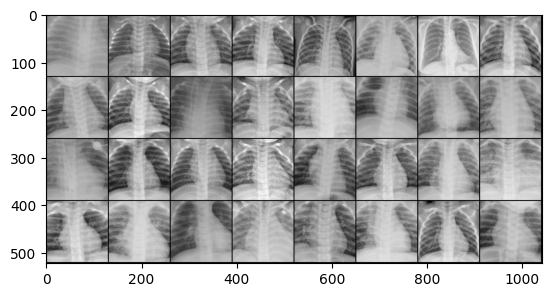

In [17]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 
inputs, classes = next(iter(loader_train))
out = tv.utils.make_grid(inputs)
imshow(out)


## Fine-Tuning:

In [18]:
def eval_corona(model, loader_val):
  model.eval()
  preds = []
  with torch.no_grad():
    for x, t in loader_val:
      x, t = x.to(device_compact), t.to(device_compact)
      logits = model(x)
      preds.append(torch.sum(torch.max(logits, dim=1)[1] == t))

  return sum(preds) / val_len

In [20]:
model = timm.create_model('vit_base_resnet50_224_in21k', pretrained=True, num_classes=num_output_classes, img_size=image_size)
model.to(device_compact)

VisionTransformer(
  (patch_embed): HybridEmbed(
    (backbone): ResNetV2(
      (stem): Sequential(
        (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
        (norm): GroupNormAct(
          32, 64, eps=1e-05, affine=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
      )
      (stages): Sequential(
        (0): ResNetStage(
          (blocks): Sequential(
            (0): Bottleneck(
              (downsample): DownsampleConv(
                (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (norm): GroupNormAct(
                  32, 256, eps=1e-05, affine=True
                  (drop): Identity()
                  (act): Identity()
                )
              )
              (conv1): StdConv2dSame(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

### Use the Default Optimizer, Loss_Function and LR_Scheduler as Train.py in the Code Source:

In [21]:
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

# weight_decay
skip = {}
if hasattr(model, 'no_weight_decay'):
    skip = model.no_weight_decay()
parameters = add_weight_decay(model, 0.0001, skip)
weight_decay = 0.

optimizer = optim.SGD(parameters, momentum=0.9, nesterov=True, lr=0.01, weight_decay=weight_decay)

In [22]:
from timm.scheduler import StepLRScheduler
from timm.loss import LabelSmoothingCrossEntropy
loss_fn = LabelSmoothingCrossEntropy(smoothing=0.1)
start_epoch = 0
num_epochs = 10
noise_range = None
lr_scheduler = StepLRScheduler(optimizer, decay_t=30, decay_rate=0.1,
               warmup_lr_init=0.0001, warmup_t=3, noise_range_t=None, noise_pct=0.67,
               noise_std=1., noise_seed=42)

### Training and Evaluating the Model:

In [20]:
iters = 10

pb_train = display(progress_bar(0, iters), display_id=True)
losses = [[]]
accus_train = [[]]
accus_val = []

for i in range(iters):
  for x, t in loader_train:
    x, t = x.to(device_compact), t.to(device_compact)
    logits = model(x)
    loss = loss_fn(logits, t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses[-1].append(loss.item())

    with torch.no_grad():
      accus_train[-1].append(torch.sum(torch.max(logits, dim=1)[1] == t))

  losses[-1] = sum(losses[-1])
  losses.append([])
  accus_train[-1] = sum(accus_train[-1]) / train_len
  accus_train.append([])

  lr_scheduler.step(i + 1)

  accus_val.append(eval_corona(model, loader_val))
  model.train()

  pb_train.update(progress_bar(i, iters))
  print(f'\r[Step {i+1}] loss={loss:.2e} '
        f'\r[Step {i+1}] loss={losses[-2]:.2e} '
        f'train accu={accus_train[-2]:.2%} '
        f'validation accu={accus_val[-1]:.2%} '
        , flush=True)

[Step 1] loss=1.34e+01 train accu=83.10% validation accu=92.40% 
[Step 2] loss=1.79e+01 train accu=55.19% validation accu=48.54% 
[Step 3] loss=1.86e+01 train accu=51.81% validation accu=51.46% 
[Step 4] loss=1.77e+01 train accu=53.82% validation accu=48.54% 
[Step 5] loss=1.75e+01 train accu=51.94% validation accu=48.54% 
[Step 6] loss=1.74e+01 train accu=52.32% validation accu=48.54% 
[Step 7] loss=1.74e+01 train accu=53.19% validation accu=51.46% 
[Step 8] loss=1.74e+01 train accu=52.32% validation accu=48.54% 
[Step 9] loss=1.74e+01 train accu=53.07% validation accu=48.54% 
[Step 10] loss=1.73e+01 train accu=55.32% validation accu=48.54% 


## Model Testing:

In [27]:

model.eval()
criterion = CrossEntropyLoss()
loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
preds = []
test_loss = 0.0
test_loss1 = 0.0

with torch.no_grad():
    for x, t in loader_test:
        x, t = x.to(device_compact), t.to(device_compact)
        logits = model(x)
        loss_test = criterion(logits, t)
        loss_11 = loss_fn(logits, t)
        test_loss1 += loss_11.detach().cpu().item() / len(test_dataset)
        test_loss += loss_test.detach().cpu().item() / len(test_dataset)
        preds.append(torch.sum(torch.max(logits, dim=1)[1] == t))

accur_test = sum(preds) / len(test_dataset)
print(accur_test)
print(accur_test.detach().cpu().item(), f"test_loss: {test_loss:.2f}", f"test_loss1: {test_loss1:.2f}")

tensor(0.4503)
0.4502924084663391 test_loss: 0.03 test_loss1: 0.03


## Getting true and predicted values:


In [28]:
y_true = []
y_pred = []

with torch.no_grad():
    for x, t in loader_test:
        x, t = x.to(device_compact), t.to(device_compact)
        outputs = model(x)
        output = torch.max(torch.exp(outputs), 1)[1]
        outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(outputs)  # Save Prediction
        y_true.extend(t.data.cpu().numpy())

print(y_true)
print(y_pred)


[0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Performance Evaluation:


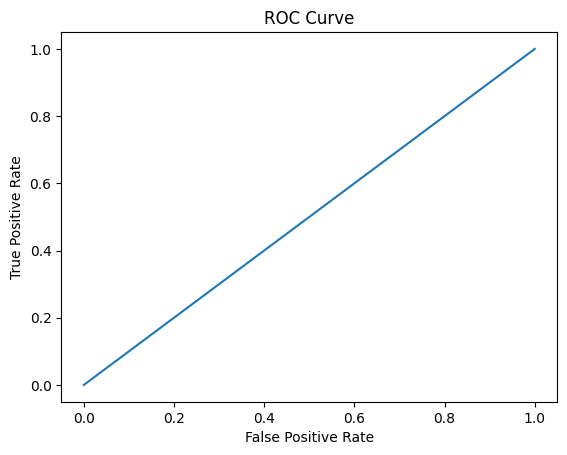

F1 Score: 0.0
Sensitivity Score: 1.0
Specificity Score: 0.0


In [31]:
def roc_plot(y_true, y_prob):
 fpr, tpr, _ = roc_curve(y_true, y_prob)
 plt.plot(fpr, tpr)
 plt.xlabel('False Positive Rate')
 plt.ylabel('True Positive Rate')
 plt.title('ROC Curve')
 plt.show()

def f1(y_true, y_pred):
 f1 = f1_score(y_true, y_pred)
 return f1.item()

def sensitivity(y_true, y_pred):
 cm = confusion_matrix(y_true, y_pred)
 return cm[0, 0] / (cm[0, 0] + cm[0, 1])

def specificity(y_true, y_pred):
 cm = confusion_matrix(y_true, y_pred)
 return cm[1, 1] / (cm[1, 0] + cm[1, 1])

roc_plot(y_true, y_pred)
f = f1(y_true, y_pred)
print("F1 Score:", f)
sens = sensitivity(y_true, y_pred)
print("Sensitivity Score:", sens)
spec = specificity(y_true, y_pred)
print("Specificity Score:", spec)


## Save Model Path:

In [32]:
save_model_path = "C:\\Users\\User\\Documents\\Capstone Project\\cp\\Project\\Kaggle\\CoronaHack\\vit_model_path.pth"
torch.save(model, save_model_path)

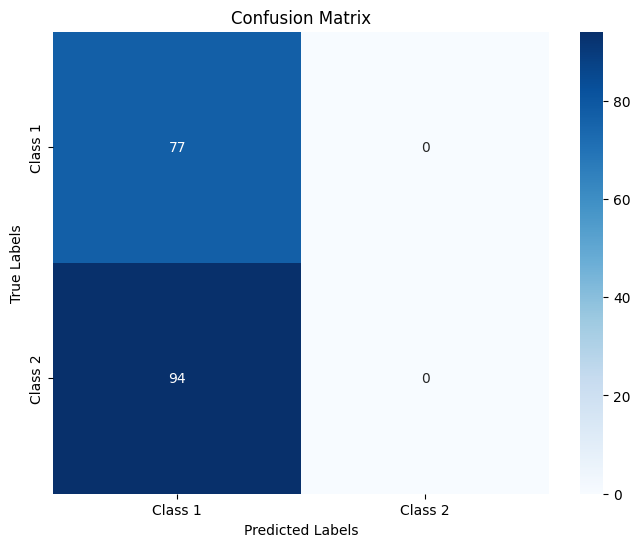

In [34]:
#Confusion Matrix:-
def plot_confusion_matrix(y_true, y_pred, class_labels):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the confusion matrix using seaborn's heatmap
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
    
    # Add labels and title
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    
    # Set the tick labels
    ax.xaxis.set_ticklabels(class_labels)
    ax.yaxis.set_ticklabels(class_labels)
    
    # Show the plot
    plt.show()

# Assuming you have class_labels available
class_labels = ['Class 1', 'Class 2']  # Replace with your actual class labels

# Generate the confusion matrix plot
plot_confusion_matrix(y_true, y_pred, class_labels)